# Catching feels
## Mood prediction pipeline

An elaborate explanation of this experiment is available at http://medium.com/maslo/catching-feels

In [1]:
import re
import os
import random
import sys
import math
import joblib

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.ensemble

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

In [2]:
sns.set(style="white", palette='muted', context='paper')

In [3]:
def get_precision(y_pred, y_true, decimal_places=False):
    '''Returns AUC, precision, recall, and accuracy
    Input: 
    y_pred: predicted values of y
    y_true: true values of y
    Output:
    AUC, precision, recall, and accuracy'''
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    acc_all = accuracy_score(y_true, y_pred)
    precision_all = precision_score(y_true, y_pred)
    tpr_all = recall_score(y_true, y_pred)
    aucs_all = auc(fpr, tpr)
    if decimal_places:
        acc_all = np.round(acc_all, decimal_places)
        aucs_all = np.round(aucs_all, decimal_places)
        precision_all = np.round(precision_all, decimal_places)
        tpr_all = np.round(tpr_all, decimal_places)
    return aucs_all, precision_all, tpr_all, acc_all

# Loading data

In [4]:
training_summary_data = pd.read_csv(
    '/Users/afrah/Desktop/catchingfeels/data/training_summary_data0622.csv')

/Users/afrah/miniconda3/envs/test/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (577,580,584,585) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
np.unique([i.split('_')[-1] for i in training_summary_data.columns])

array(['Actor', 'Age', 'Emotion', 'Ethnicity', 'Intensity', 'Race', 'Sex',
       'Statement', 'bw', 'centroid', 'cnst0', 'cnst1', 'cnst2', 'cnst3',
       'cnst4', 'cnst5', 'cnst6', 'directory', 'filename', 'flat',
       'mfcc0', 'mfcc1', 'mfcc10', 'mfcc11', 'mfcc12', 'mfcc13', 'mfcc14',
       'mfcc15', 'mfcc16', 'mfcc17', 'mfcc18', 'mfcc19', 'mfcc2',
       'mfcc20', 'mfcc21', 'mfcc22', 'mfcc23', 'mfcc24', 'mfcc25',
       'mfcc26', 'mfcc27', 'mfcc28', 'mfcc29', 'mfcc3', 'mfcc30',
       'mfcc31', 'mfcc32', 'mfcc33', 'mfcc34', 'mfcc35', 'mfcc36',
       'mfcc37', 'mfcc38', 'mfcc39', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
       'mfcc8', 'mfcc9', 'poly0', 'poly1', 'poly10', 'poly2', 'poly3',
       'poly4', 'poly5', 'poly6', 'poly7', 'poly8', 'poly9', 'rms',
       'rolloff', 'zcr'], dtype='<U9')

In [6]:
# keeping track of performance across models
performances = []

The summary statistics (Median, Variance, Minimum, Maximum) for the following features were used as training features for all prediction models
* Polynomial coefficients
* Mel-frequency cepstral coefficients
* Spectral contrast
* Spectral centroid
* Spectral flatness
* Spectral rolloff
* Root mean square
* Zero crossing rate

In [7]:
# Feature names used
feature_names = ['mfcc' + str(i) for i in np.arange(40)] + [
    'poly' + str(i) for i in np.arange(11)] + [
         'spectral_bw', 'spectral_centroid'
     ] + ['spectral_cnst' + str(i) for i in np.arange(7)
          ] + ['spectral_flat', 'spectral_rolloff', 'rms', 'zcr']

all_feature_names = []

for j in ['median', 'min', 'max', 'var']:
    all_feature_names += [str.join('_', [j, i]) for i in feature_names]

# Sex prediction model

The purpose of this prediction model is to predict Gender/Sex of the individuals in the dataset based on the training features used in the models. As a gender-specific effect is observed in mood prediction, this model will allow predicting the gender/sex of future Maslo recordings and be used to make appropriate gender-based predictions

In [8]:
X = np.array(training_summary_data[all_feature_names])
y = np.array(training_summary_data.Sex)
codes, uniques = pd.factorize(training_summary_data['Actor'])

## Parameter tuning

Parameter tuning is performed on 50% of the training data set to prevent over-fitting to the current dataset.

In [9]:
# parameter_grid = {
#     'n_estimators': [100, 300, 500, 700, 1000, 1500, 2000],
#     'max_features': ['auto', 'sqrt'],
#     'max_depth': [50, 100, 300, 500, 1000, 1500, 2000, None]
# }

In [10]:
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.5,
#                                                     train_size=0.5)

# clf = RandomizedSearchCV(
#     sklearn.ensemble.RandomForestClassifier(),
#     parameter_grid,
#     random_state=42).fit(X_train, y_train)
# print(search.best_params_)

## Cross validation

Crossvalidation is used to quantify the performance of the model. Repeated Cross-validation (5 repeats, 5 splits = 25 total splits) is used as the dataset is quite small for a problem so complex and thorough cross-validation is needed to quantify the performance of the models. 

In [11]:
for k in range(3):
    groups_kfold = sklearn.model_selection.GroupShuffleSplit(test_size=.2,
                                                             train_size=0.8,
                                                             n_splits=2)
    # codes used for group splits to avoid the same actor being in train/test splits
    groups_kfold.get_n_splits(X, y, codes)
    for train_index, test_index in groups_kfold.split(X, y, codes):
        X_train = X[train_index, :]
        X_test = X[test_index, :]

        y_train = y[train_index]
        y_test = y[test_index]

        sex_rf = sklearn.ensemble.RandomForestClassifier(n_estimators=2000,
                                                 max_depth=1000,
                                                 max_features='sqrt').fit(
                                                     X_train, y_train)
        y_pred = sex_rf.predict(X_test)
        for mood in np.unique(y_test):
            performances += [[mood] + list(
                get_precision(np.array(pd.get_dummies(y_pred)[mood]),
                              np.array(pd.get_dummies(y_test)[mood]), 2)) +
                             ['gender-prediction']]

## Feature prediction

Text(0.5, 0, 'Feature importance')

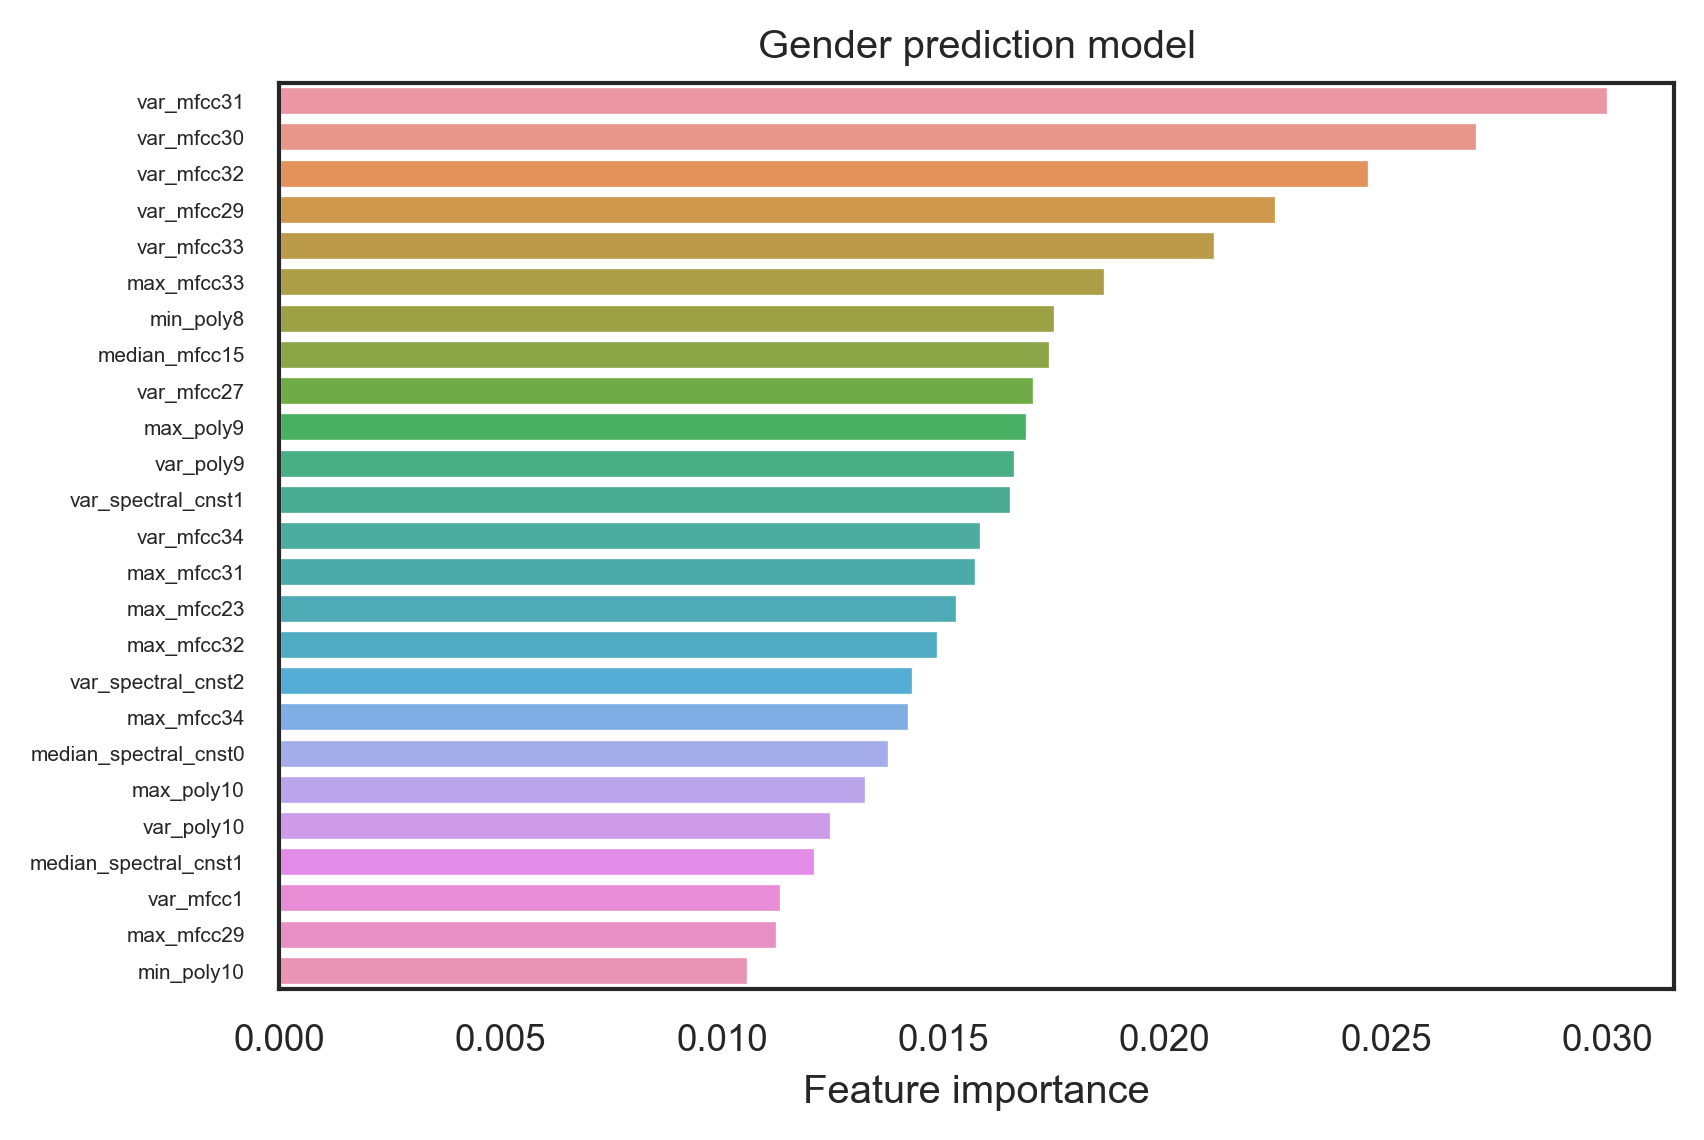

In [12]:
plt.figure(dpi=300)
features_importance = pd.Series(sex_rf.feature_importances_,
                                index=all_feature_names).nlargest(25)
ax = sns.barplot(x=list(features_importance),
                 y=[str(i) for i in features_importance.index])
ticks = ax.get_yticklabels()
ax.set_yticklabels(ticks, fontsize=5)
plt.title('Gender prediction model')
plt.xlabel('Feature importance')

# Mood prediction

## Gender-nonspecific prediction model

To predict moods, we focus on predicting 'happy', 'angry', 'neutral' and 'sad' labels due to the limited training samples. This model doesnt take the gender/sex of the person into account and makes predictions for all samples

In [13]:
# # Can we predict mood?
training_sub = training_summary_data[
    training_summary_data.Emotion.apply(  # Excluding other emotions
        lambda x: x not in ['surprise', 'disgust', 'fearful', 'calm'])]
X = np.array(training_sub[all_feature_names])
y = np.array(training_sub.Emotion)

codes, uniques = pd.factorize(training_sub['Actor'])

### Parameter tuning

In [14]:
# X_train, X_test, y_train, y_test = train_test_split(X,
#                                                     y,
#                                                     test_size=0.5,
#                                                     train_size=0.5)
# clf = RandomizedSearchCV(
#     sklearn.ensemble.RandomForestClassifier(),
#     parameter_grid)
# search = clf.fit(X_train, y_train)
# print(search.best_params_)

### Cross validation 

In [16]:
for k in range(3):
    groups_kfold = sklearn.model_selection.GroupShuffleSplit(test_size=.2,
                                                             train_size=0.8,
                                                             n_splits=2)
    # codes used for group splits to avoid the same actor being in train/test splits
    groups_kfold.get_n_splits(X, y, codes)
    for train_index, test_index in groups_kfold.split(X, y, codes):
        X_train = X[train_index, :]
        X_test = X[test_index, :]

        y_train = y[train_index]
        y_test = y[test_index]

        mood_mf8_rf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=500, max_depth=1000,
            max_features='sqrt').fit(X_train, y_train)
        
        y_pred_test_mf8 = mood_mf8_rf.predict(X_test)
        
        for mood in np.unique(y_test):
            performances += [[mood] + list(
                get_precision(np.array(pd.get_dummies(y_pred_test_mf8)[mood]),
                              np.array(pd.get_dummies(y_test)[mood]), 2)) +
                             ['gender-nonspecific-model']]

### Features importance

Text(0.5, 0, 'Feature importance')

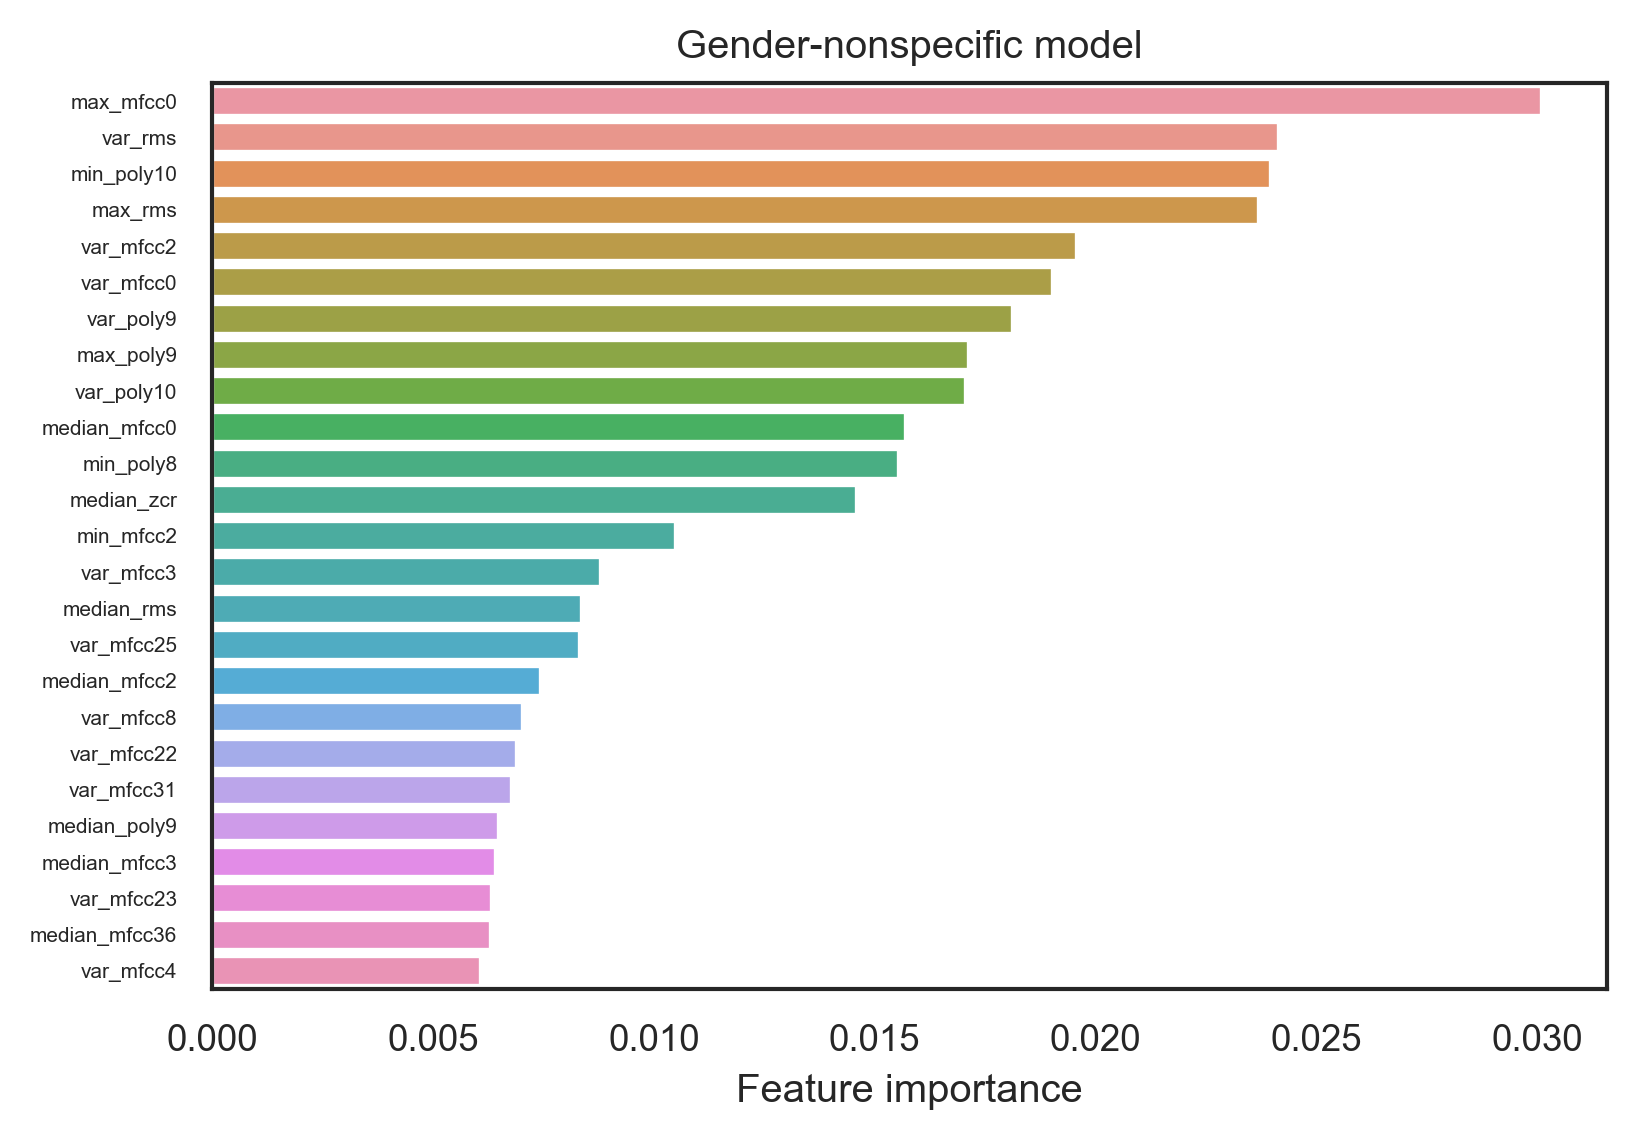

In [17]:
plt.figure(dpi=300)
features_importance = pd.Series(mood_mf8_rf.feature_importances_,
                                index=all_feature_names).nlargest(25)
ax = sns.barplot(x=list(features_importance),
                 y=[str(i) for i in features_importance.index])
ticks = ax.get_yticklabels()
ax.set_yticklabels(ticks, fontsize=5)
plt.title('Gender-nonspecific model')
plt.xlabel('Feature importance')

## Male-specific prediction model

In [18]:
# # Can we predict mood?
training_sub_male = training_sub[
    training_sub.Sex.apply(  # Excluding other emotions
        lambda x: x !='Female')]
X = np.array(training_sub_male[all_feature_names])
y = np.array(training_sub_male.Emotion)
codes, uniques = pd.factorize(training_sub_male['Actor'])

In [19]:
for k in range(3):
    groups_kfold = sklearn.model_selection.GroupShuffleSplit(test_size=.2,
                                                             train_size=0.8,
                                                             n_splits=2)
    # codes used for group splits to avoid the same actor being in train/test splits
    groups_kfold.get_n_splits(X, y, codes)
    for train_index, test_index in groups_kfold.split(X, y, codes):
        X_train = X[train_index, :]
        X_test = X[test_index, :]

        y_train = y[train_index]
        y_test = y[test_index]

        mood_m8_rf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=2000, max_depth=1000,
            max_features='sqrt').fit(X_train, y_train)
        
        y_pred_test_m8 = mood_m8_rf.predict(X_test)
        
        for mood in np.unique(y_test):
            performances += [[mood] + list(
                get_precision(np.array(pd.get_dummies(y_pred_test_m8)[mood]),
                              np.array(pd.get_dummies(y_test)[mood]), 2)) +
                             ['male-specific-model']]

### Features importance

Text(0.5, 0, 'Feature importance')

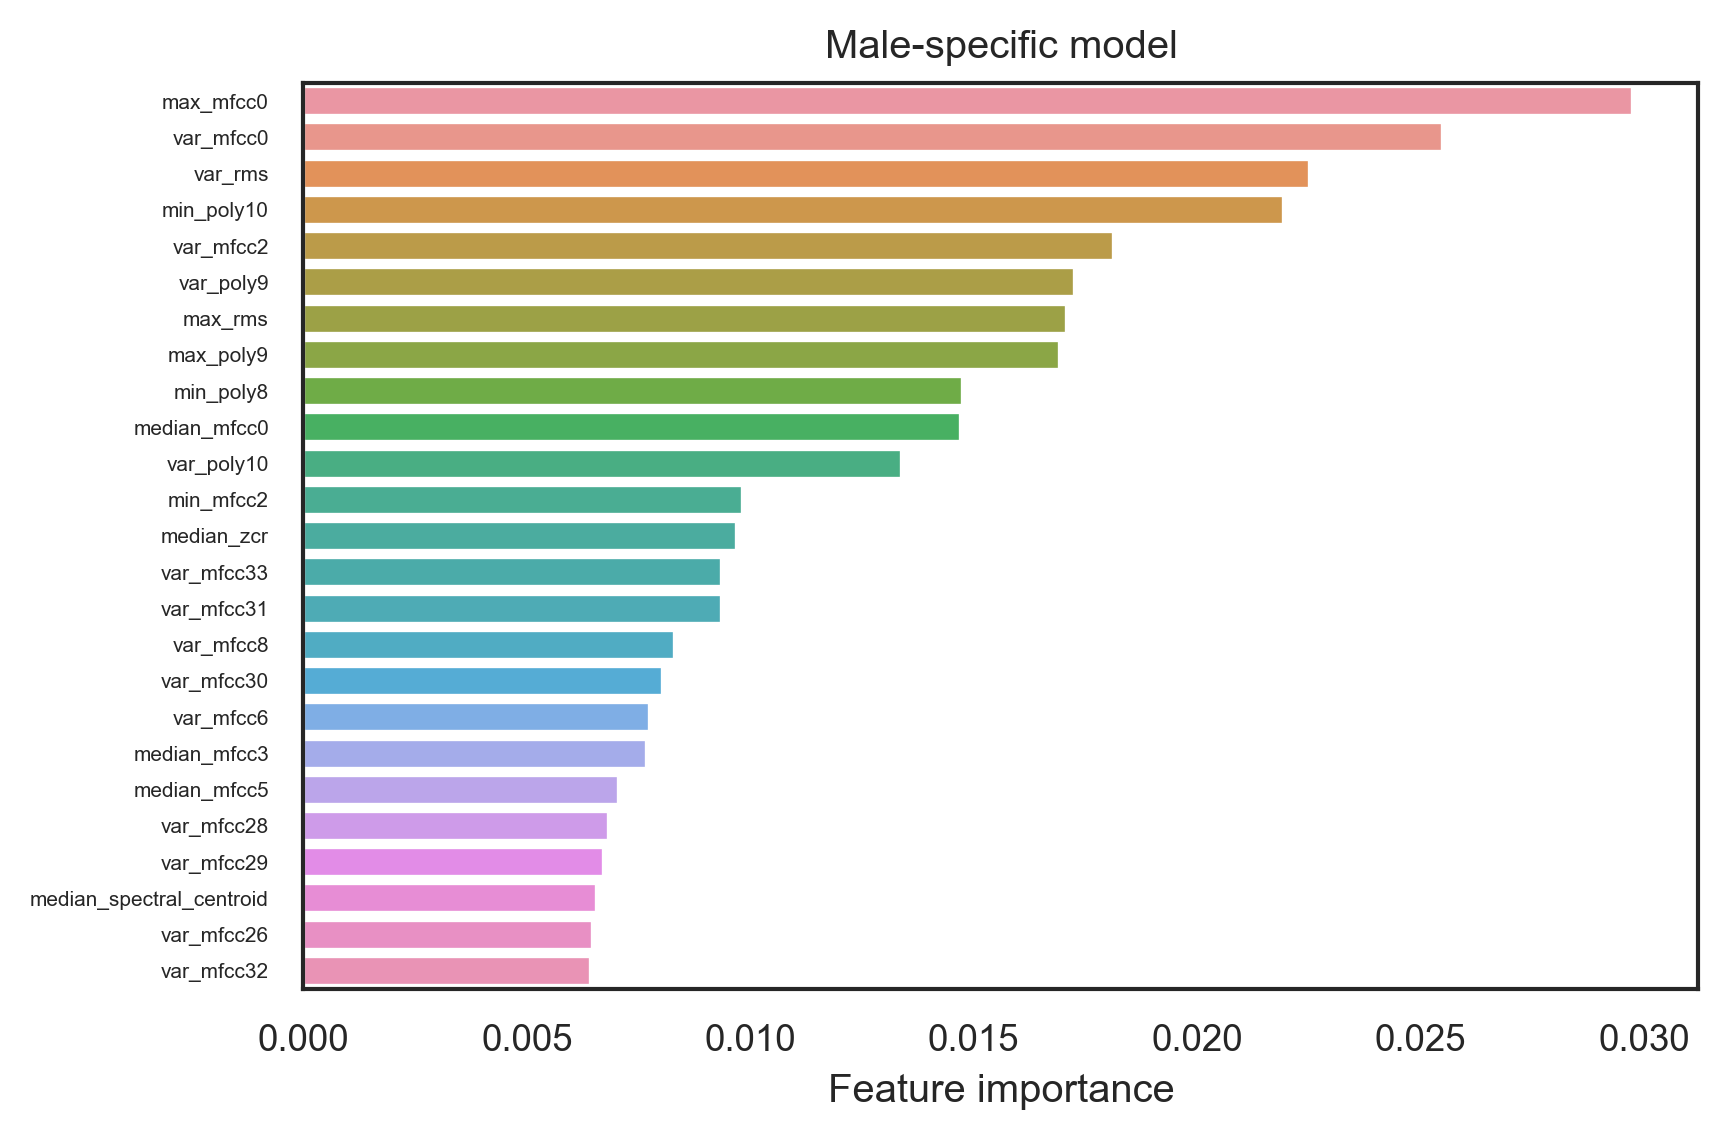

In [20]:
plt.figure(dpi=300)
features_importance = pd.Series(mood_m8_rf.feature_importances_,
                                index=all_feature_names).nlargest(25)
ax = sns.barplot(x=list(features_importance),
                 y=[str(i) for i in features_importance.index])
ticks = ax.get_yticklabels()
ax.set_yticklabels(ticks, fontsize=5)
plt.title('Male-specific model')
plt.xlabel('Feature importance')

## Female-specific prediction model

In [21]:
# # Can we predict mood?
training_sub_female = training_sub[
    training_sub.Sex.apply(  # Excluding other emotions
        lambda x: x =='Female')]
X = np.array(training_sub_female[all_feature_names])
y = np.array(training_sub_female.Emotion)
codes, uniques = pd.factorize(training_sub_female['Actor'])

In [22]:
for k in range(3):
    groups_kfold = sklearn.model_selection.GroupShuffleSplit(test_size=.2,
                                                             train_size=0.8,
                                                             n_splits=2)
    # codes used for group splits to avoid the same actor being in train/test splits
    groups_kfold.get_n_splits(X, y, codes)
    for train_index, test_index in groups_kfold.split(X, y, codes):
        X_train = X[train_index, :]
        X_test = X[test_index, :]

        y_train = y[train_index]
        y_test = y[test_index]

        mood_f8_rf = sklearn.ensemble.RandomForestClassifier(
            n_estimators=1500, max_depth=300,
            max_features='sqrt').fit(X_train, y_train)
        
        y_pred_test_f8 = mood_f8_rf.predict(X_test)
        
        for mood in np.unique(y_test):
            performances += [[mood] + list(
                get_precision(np.array(pd.get_dummies(y_pred_test_f8)[mood]),
                              np.array(pd.get_dummies(y_test)[mood]), 2)) +
                             ['female-specific-model']]

### Features importance

Text(0.5, 0, 'Feature importance')

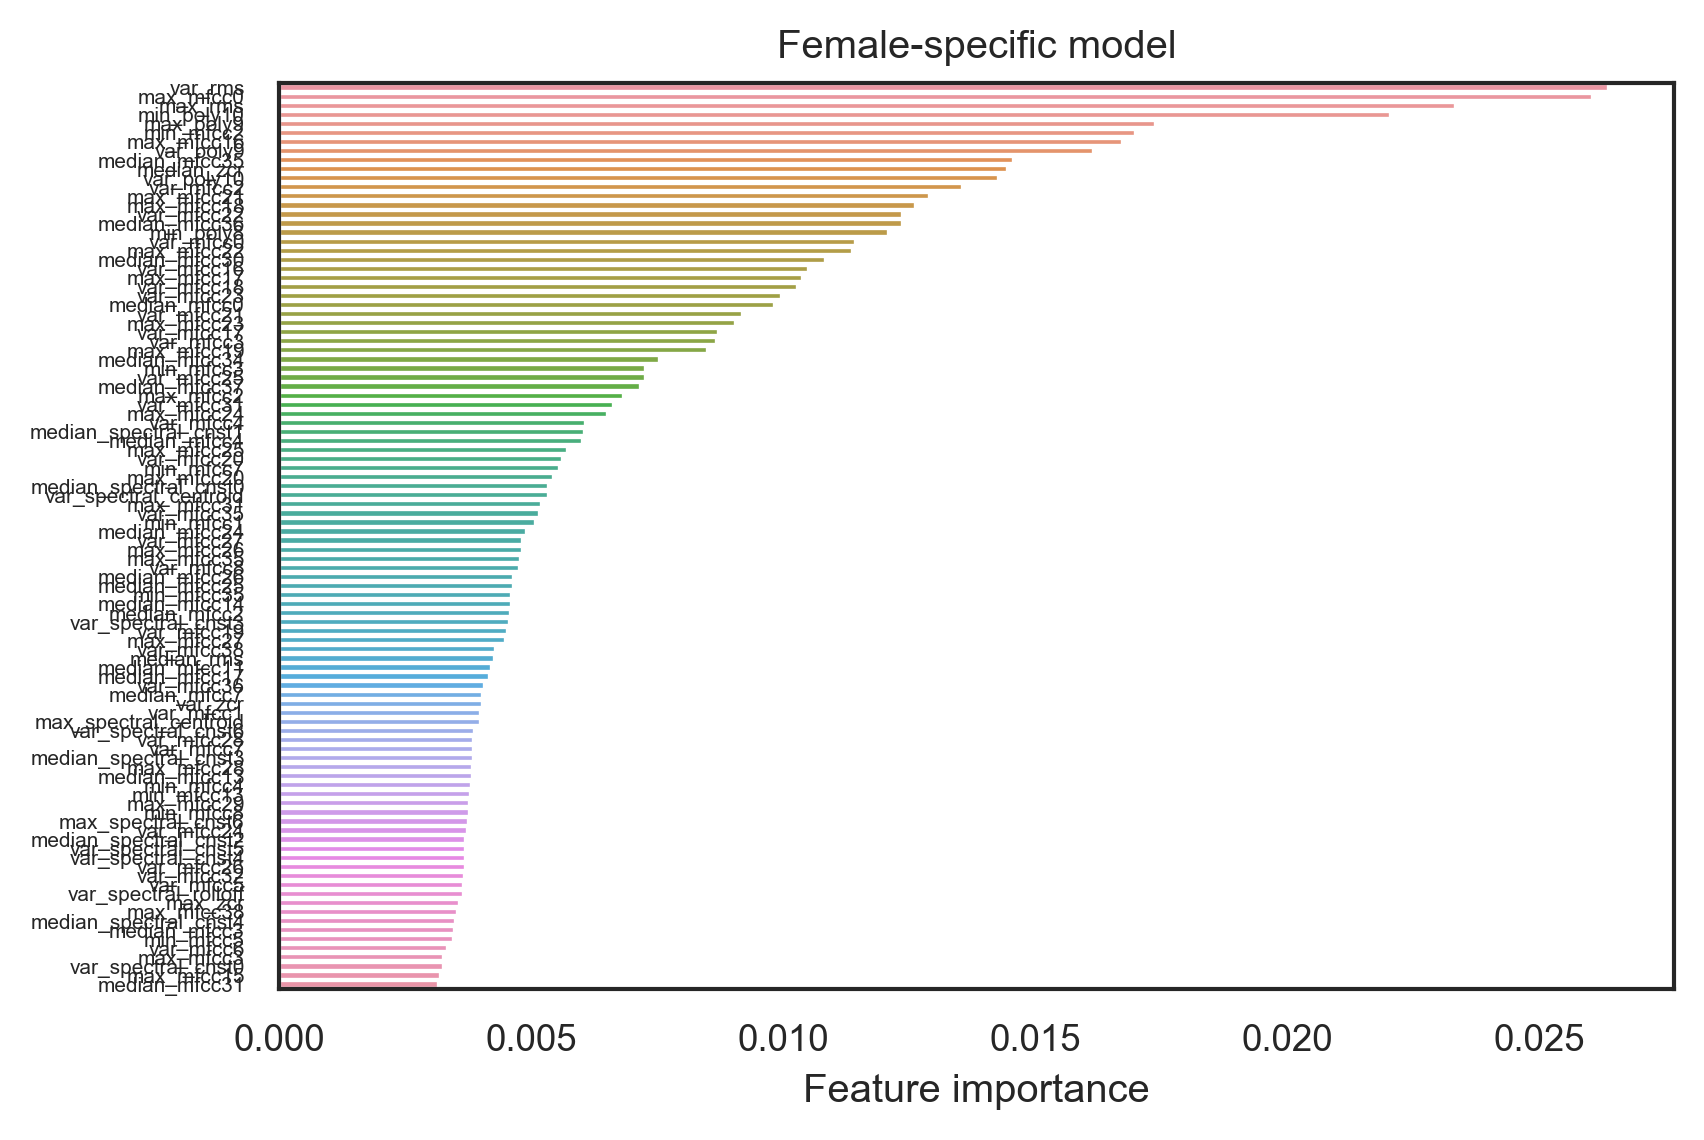

In [23]:
plt.figure(dpi=300)
features_importance = pd.Series(mood_f8_rf.feature_importances_,
                                index=all_feature_names).nlargest(100)
ax = sns.barplot(x=list(features_importance),
                 y=[str(i) for i in features_importance.index])
ticks = ax.get_yticklabels()
ax.set_yticklabels(ticks, fontsize=5)
plt.title('Female-specific model')
plt.xlabel('Feature importance')

# Comparison of models' performance 

In [24]:
df_performances = pd.DataFrame(performances)
df_performances.columns = [
    'Prediction', 'AUC', 'Precision', 'Recall', 'Accuracy', 'Model'
]

In [25]:
df_performances.to_csv('../data/df_performances.csv.gz', index=False)

## Mood predictions

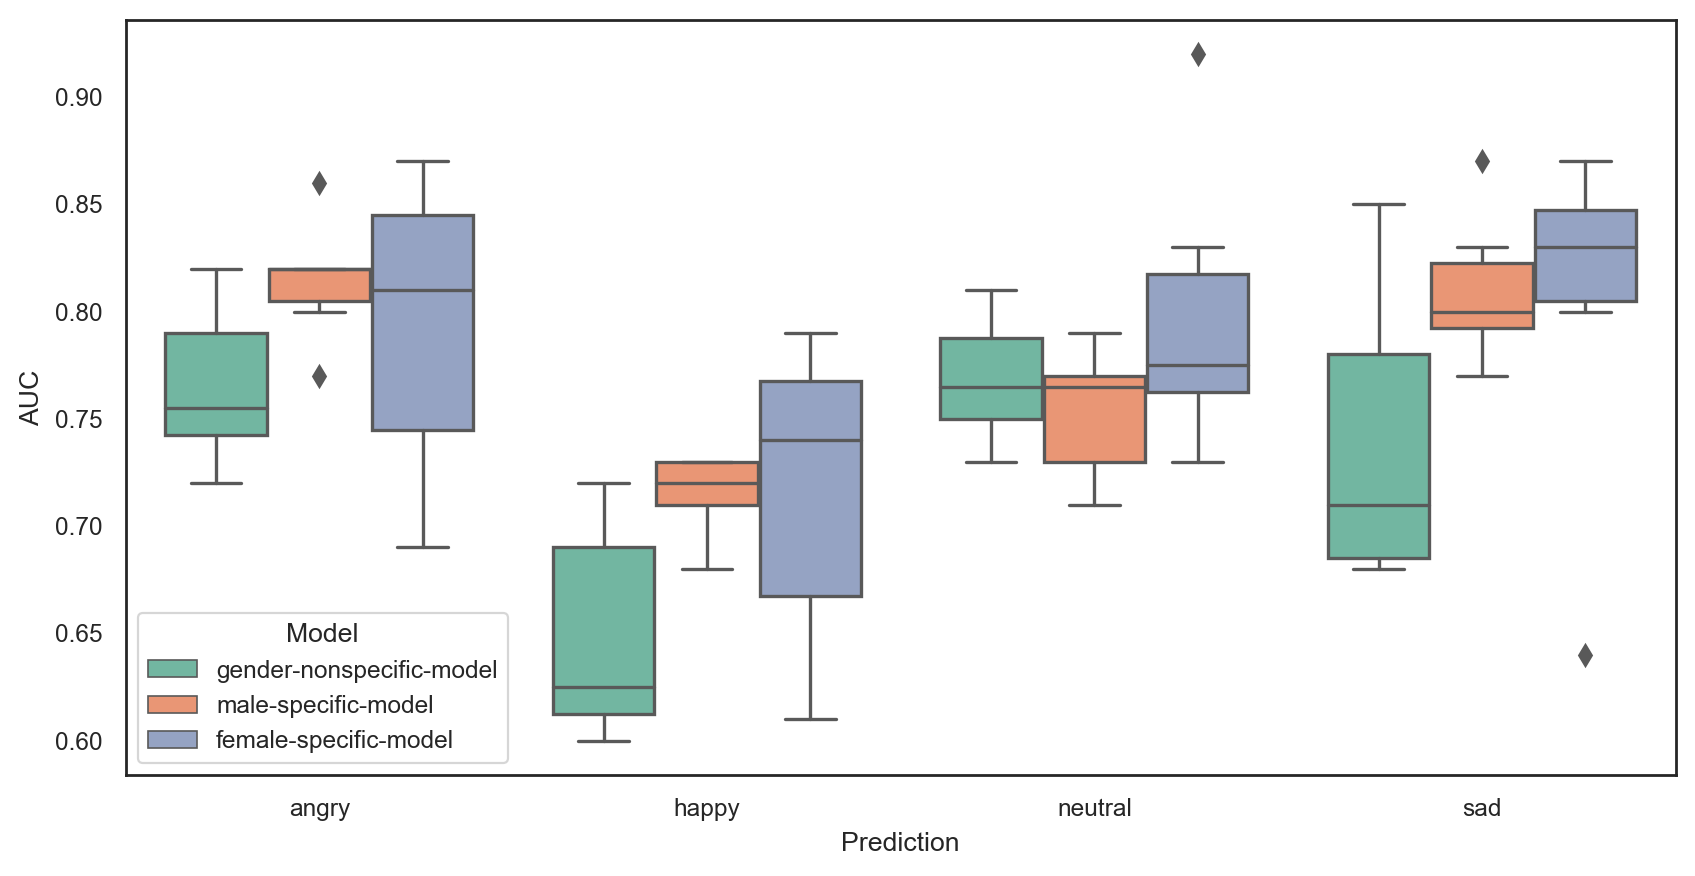

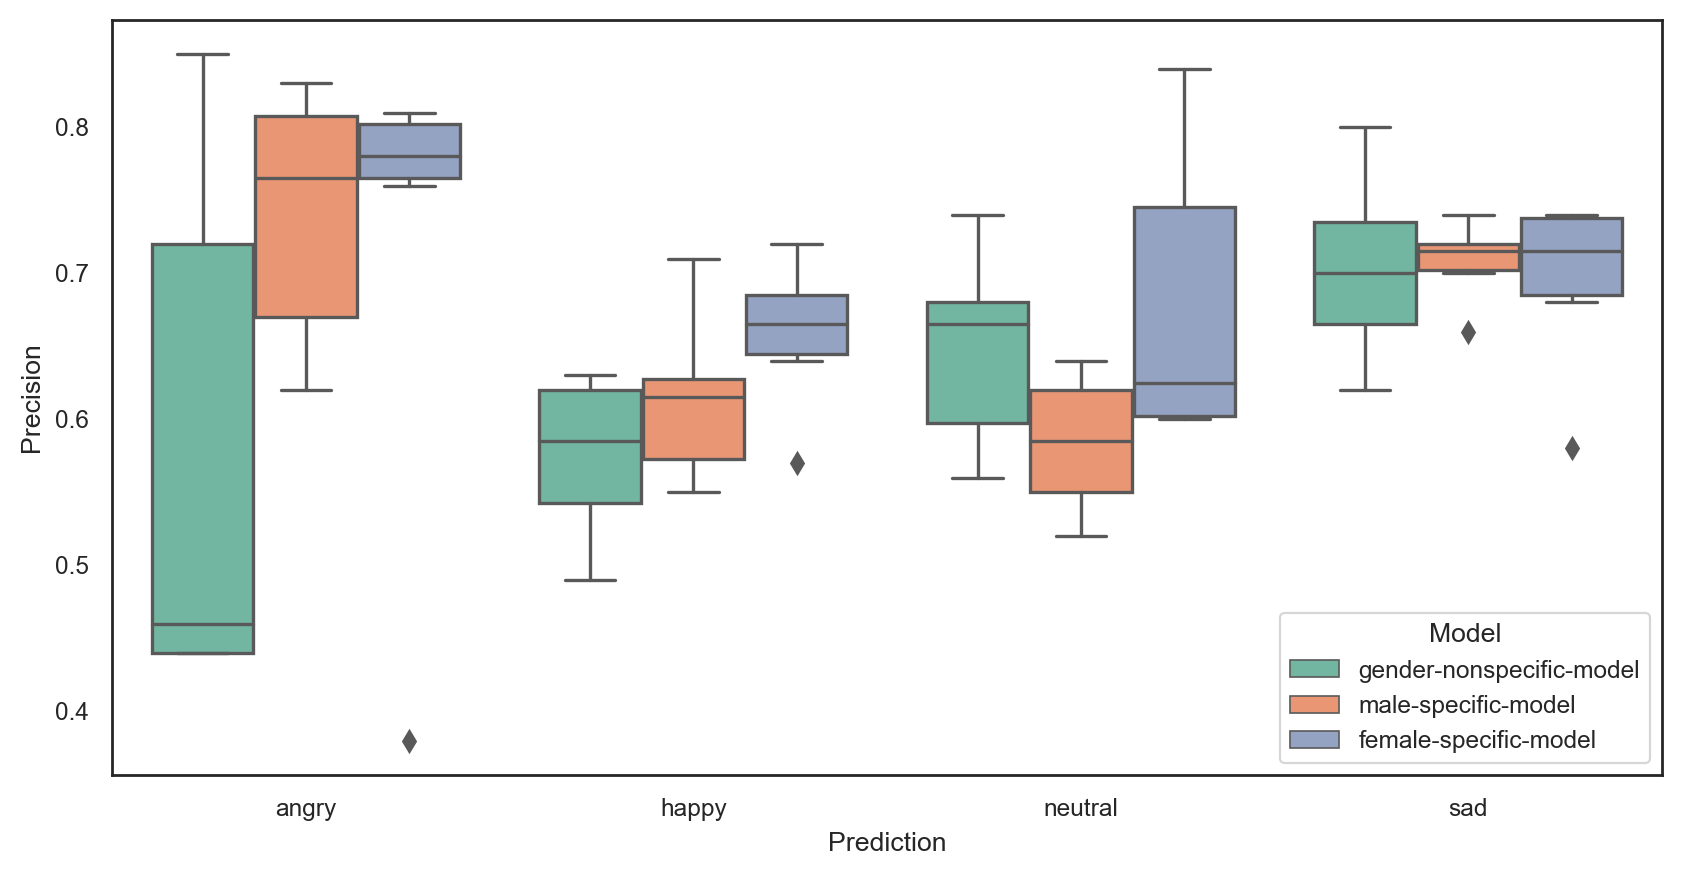

In [26]:
plt.figure(dpi=200, figsize=(10, 5))
sns.boxplot(x='Prediction',
            y='AUC',
            hue='Model',
            data=df_performances[df_performances.Model != 'ensemble'],
            palette='Set2')
plt.savefig('../figs/moodmodels_auc.pdf', dpi=300)
plt.figure(dpi=200, figsize=(10, 5))
sns.boxplot(x='Prediction',
            y='Precision',
            hue='Model',
            data=df_performances[df_performances.Model != 'ensemble'],
            palette='Set2')
plt.savefig('../figs/moodmodels_precision.pdf', dpi=300)

## Sex prediction

In [ ]:
plt.figure(dpi=300, figsize=(15, 10))

sns.barplot(x='Prediction',
            y='AUC',
            hue='Prediction',
            data=df_performances[df_performances.Model == 'gender-prediction'],
            palette='Set2')
plt.savefig('../figs/sex_auc.pdf', dpi=300)
plt.figure(dpi=300, figsize=(15, 10))
sns.barplot(x='Prediction',
            y='Precision',
            hue='Prediction',
            data=df_performances[df_performances.Model == 'gender-prediction'],
            palette='Set2')
plt.savefig('../figs/sex_precision.pdf', dpi=300)

## Computing median AUC across models-predictions

In [ ]:
df_performances.groupby(['Model', 'Prediction']).median()

# Comparison of top features across models

Here we look at the features that are important across all models and compare their feature importances with each other. Comparing feature importances we observe that higher MFCCs are more important in female-specific models than male-specific/gender-specific models.

In [ ]:
features_arr = np.vstack([
    mood_mf8_rf.feature_importances_, mood_m8_rf.feature_importances_,
    mood_f8_rf.feature_importances_
])
features_df = pd.DataFrame(features_arr)
features_df.columns = all_feature_names
features_df.index = ['mf', 'm', 'f']

In [ ]:
dict_features = {}
for i in all_feature_names:
    if 'mfcc' in i:
        dict_features[i] = 'darkblue'
    elif 'poly' in i:
        dict_features[i] = 'orange'
    elif 'rms' in i:
        dict_features[i] = 'darkgray'
    elif 'bw' in i:
        dict_features[i] = 'y'
    elif 'zcr' in i:
        dict_features[i] = 'turquoise'
    elif 'rolloff' in i:
        dict_features[i] = 'purple'
    elif 'flat' in i:
        dict_features[i] = 'pink'
    elif 'cnst' in i:
        dict_features[i] = 'pink'
    else:
        dict_features[i] = 'cyan'

top_features = np.unique(
    list(
        pd.Series(mood_mf8_rf.feature_importances_,
                  index=all_feature_names).nlargest(15).index) + list(
                      pd.Series(mood_f8_rf.feature_importances_,
                                index=all_feature_names).nlargest(15).index) +
    list(
        pd.Series(mood_m8_rf.feature_importances_,
                  index=all_feature_names).nlargest(15).index))

In [ ]:
df = features_df[top_features] 
df = df.transpose()
row_colors = df.index.map(dict_features)
sns.clustermap(df, row_colors=row_colors)
plt.savefig('../figs/heatmap_moodmodels.pdf', dpi=300)